In [1]:
import geopandas as gpd
import momepy
import pandana
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx
import folium
import pysal
import numpy

from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.lines import Line2D
from geemap import cartoee

c:\Users\b9066009\Anaconda3\envs\geo_env\lib\site-packages\pysal\explore\segregation\network\network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
c:\Users\b9066009\Anaconda3\envs\geo_env\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


cartopy is not installed. Please see https://scitools.org.uk/cartopy/docs/latest/installing.html#installing for instructions on how to install cartopy.

The easiest way to install cartopy is using conda: conda install -c conda-forge cartopy


In [2]:
local_crs = 2154

In [3]:
# load data
streets = gpd.read_parquet('./data/streets.parquet')
hexagons = gpd.read_parquet('./data/hexagons.parquet')
centroids = gpd.read_parquet('./data/centroids.parquet')
hexagons_sa = gpd.read_parquet('./data/hexagons_sa.parquet')

In [4]:
## generate pandana network
# nodes and edges for walk network
nodes_walk, edges_walk = momepy.nx_to_gdf( # convert network to gdf
    momepy.gdf_to_nx( # convert to nx graph
        streets.explode() # remove multipart rows
    )
)
nodes_walk = nodes_walk.set_index('nodeID') # set index

# generate walk pandana network
streets_pdna = pandana.Network( 
    nodes_walk.geometry.x,
    nodes_walk.geometry.y,
    edges_walk['node_start'], # set origins
    edges_walk['node_end'], # set destinations
    edges_walk[['mm_len']] # set edge length
)

C:\Users\b9066009\AppData\Local\Temp\ipykernel_23644\1189012362.py:5: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  streets.explode() # remove multipart rows


## Analysis for adults

In [5]:
# attach pois to the network
streets_pdna.set_pois( # snap pois to network
    category = 'pois', # set name of the new layer snapped on the network
    maxdist = 1125, # set maximum distance
    maxitems = 700, # set maximum number of pois to look for
    x_col = centroids.geometry.x,
    y_col = centroids.geometry.y
)
results = streets_pdna.nearest_pois( # calculate distances to pois
    distance = 1125, # maximum distance
    category = 'pois', # layer where we want to look for
    num_pois = 700, # max number of pois to look for
    include_poi_ids = True # include pois ids
)


In [6]:
# store results separately as distances and centroids

# separate distances from poi ids
distances = results.iloc[:,:round(len(results.columns)/2,)] # create df with distances
pois_ids = results.iloc[:,round(len(results.columns)/2,):] # create df with pois ids

# convert wide matrices to long
distances_long = pd.melt(distances.reset_index(), id_vars='nodeID',value_name='distance') # make matrix long
pois_ids_long = pd.melt(pois_ids.reset_index(), id_vars='nodeID',value_name='centroidID') # make matrix long

# create an od long df containing nodeID, distance, and poiID
od = distances_long
od['centroidID'] = pois_ids_long['centroidID'] # set a column with pois ids (as they are indexed, they are already in the right order)

# format od matrix and drop NAs
od = od[['nodeID','centroidID','distance']] # clean columns
od = od.dropna() # drop NAs

# calculate nearest node to each centroid
centroids['nodeID'] = streets_pdna.get_node_ids(centroids.geometry.x, centroids.geometry.y)
centroids = centroids.reset_index()

od = pd.merge(od, centroids)

access = od.groupby(['index']).size().reset_index()
access = access.rename(columns= {0:'access'})

#access_score_adults = pd.merge(hexagons, access, left_on='hex_id', right_on='index')

In [7]:
access_score_adults = pd.merge(hexagons_sa, access, left_on='hex_id', right_on='index')

In [8]:
import mapclassify

In [12]:
# custom classes
classi = mapclassify.UserDefined(
    access_score_adults['access'],[300,450, 600,700]
)
classi

UserDefined             

    Interval       Count
------------------------
[141.00, 300.00] |   113
(300.00, 450.00] |   164
(450.00, 600.00] |   643
(600.00, 700.00] | 12002

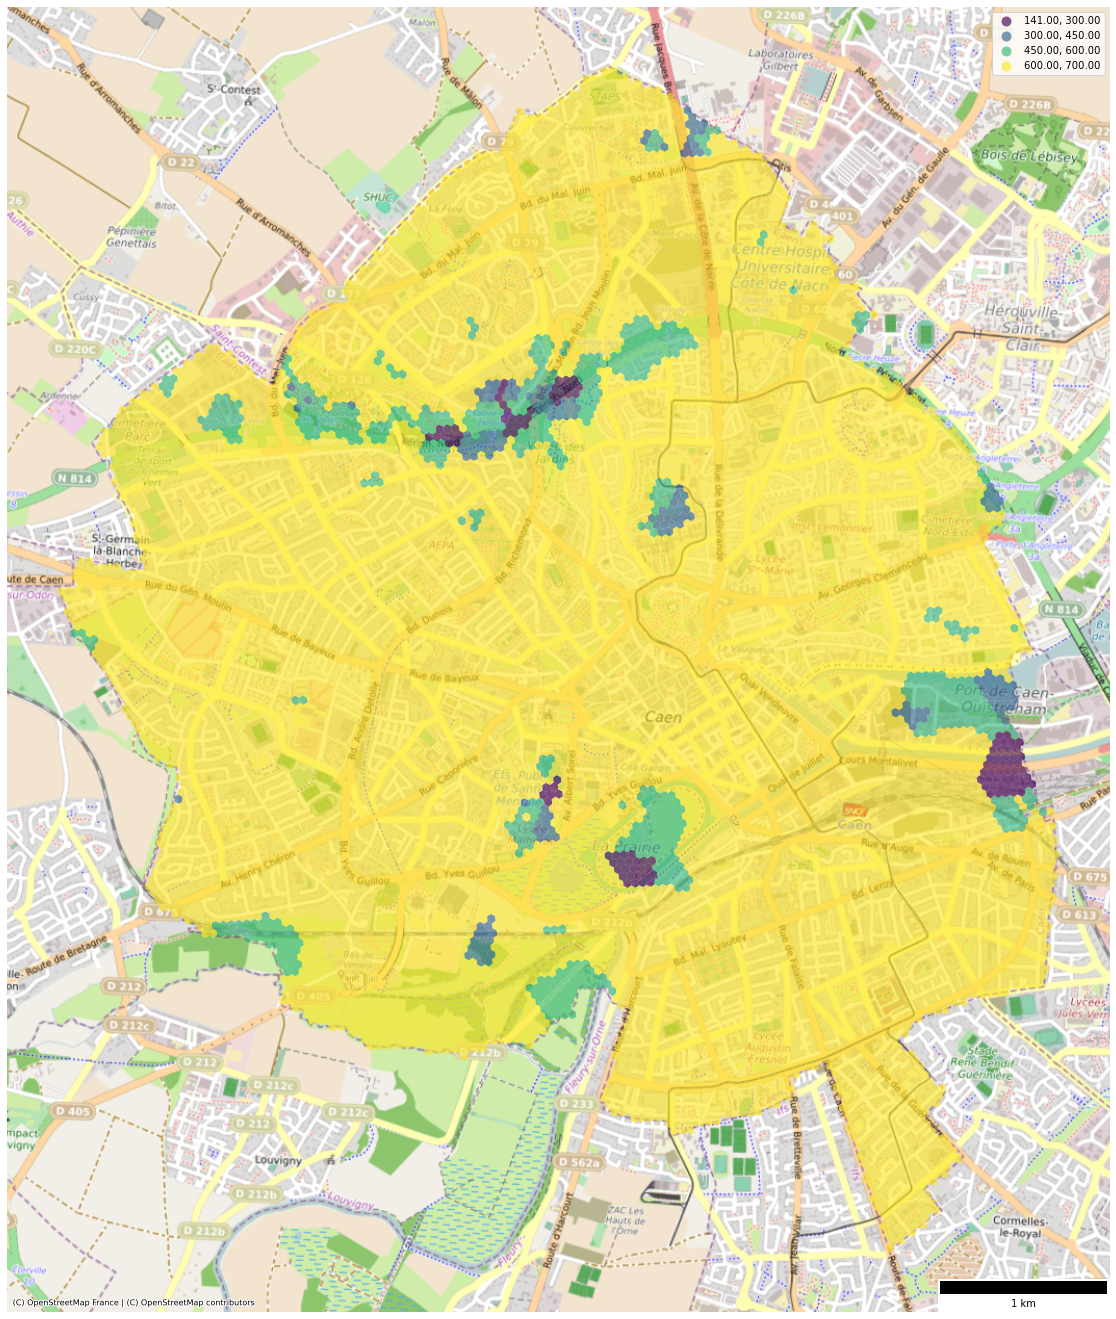

In [36]:
f, ax = plt.subplots(1, figsize=(24,24))
ax = access_score_adults.to_crs(local_crs).plot(ax = ax, 
                                         column = 'access',
                                         scheme = 'user_defined',
                                         classification_kwds={'bins':[300,450, 600,700]},
                                         legend = True,
                                         alpha = 0.65)

ax.tick_params(labelsize = 20)

cx.add_basemap(ax,
               crs=local_crs,
               source = cx.providers.OpenStreetMap.France)

ax.set_axis_off()


scalebar = ScaleBar(dx=1,
                    location=(4),
                    height_fraction=0.01
                    )
ax.add_artist(scalebar)

fig = ax.figure
cb_ax = fig.axes[0]
cb_ax.tick_params(labelsize=20)

plt.savefig('./figures/access_score_adults.png', bbox_inches='tight')

In [41]:
access_score_adults.to_parquet('./results/access_score_adults.parquet')

C:\Users\b9066009\AppData\Local\Temp\ipykernel_23644\2924953290.py:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  access_score_adults.to_parquet('./results/access_score_adults.parquet')


## Analysis for seniors

In [33]:
## Analysis for seniors
# attach pois to the network
streets_pdna.set_pois( # snap pois to network
    category = 'pois', # set name of the new layer snapped on the network
    maxdist = 800, # set maximum distance
    maxitems = 700, # set maximum number of pois to look for
    x_col = centroids.geometry.x,
    y_col = centroids.geometry.y
)
results = streets_pdna.nearest_pois( # calculate distances to pois
    distance = 800, # maximum distance
    category = 'pois', # layer where we want to look for
    num_pois = 700, # max number of pois to look for
    include_poi_ids = True # include pois ids
)

# store results separately as distances and centroids

# separate distances from poi ids
distances = results.iloc[:,:round(len(results.columns)/2,)] # create df with distances
pois_ids = results.iloc[:,round(len(results.columns)/2,):] # create df with pois ids

# convert wide matrices to long
distances_long = pd.melt(distances.reset_index(), id_vars='nodeID',value_name='distance') # make matrix long
pois_ids_long = pd.melt(pois_ids.reset_index(), id_vars='nodeID',value_name='centroidID') # make matrix long

# create an od long df containing nodeID, distance, and poiID
od = distances_long
od['centroidID'] = pois_ids_long['centroidID'] # set a column with pois ids (as they are indexed, they are already in the right order)

# format od matrix and drop NAs
od = od[['nodeID','centroidID','distance']] # clean columns
od = od.dropna() # drop NAs

# calculate nearest node to each centroid
centroids['nodeID'] = streets_pdna.get_node_ids(centroids.geometry.x, centroids.geometry.y)
centroids = centroids.reset_index()

od = pd.merge(od, centroids)

access = od.groupby(['index']).size().reset_index()
access = access.rename(columns= {0:'access'})

access_score_seniors = pd.merge(hexagons_sa, access, left_on='hex_id', right_on='index')

In [42]:
access_score_seniors.to_parquet('./results/access_score_seniors.parquet')

C:\Users\b9066009\AppData\Local\Temp\ipykernel_23644\1512263804.py:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  access_score_seniors.to_parquet('./results/access_score_seniors.parquet')


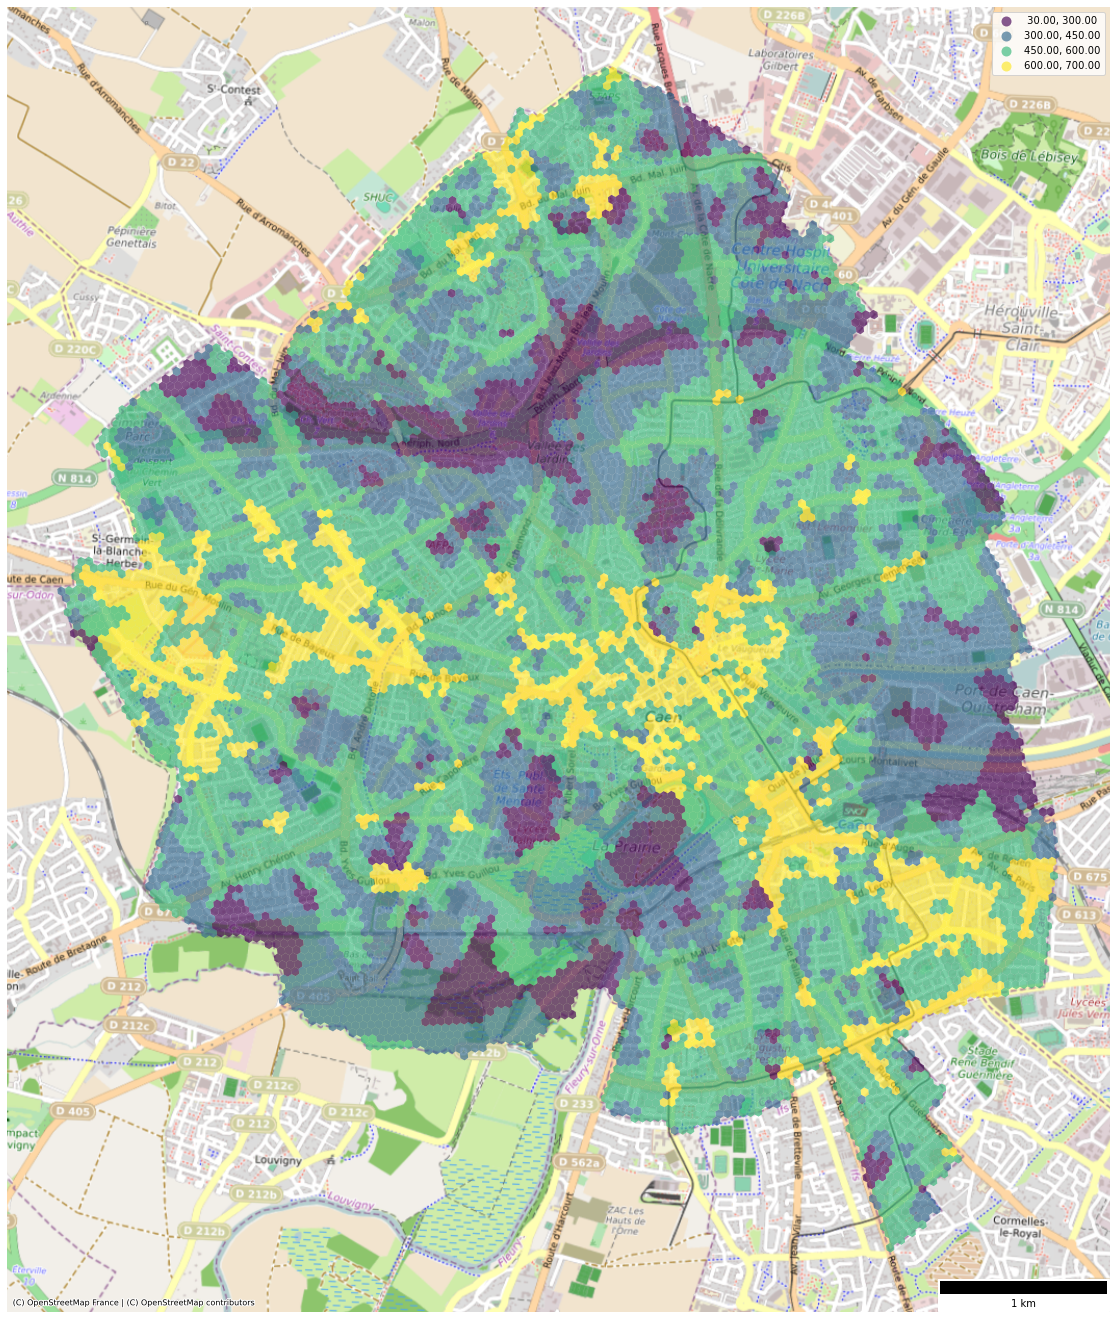

In [38]:
f, ax = plt.subplots(1, figsize=(24,24))
ax = access_score_seniors.to_crs(local_crs).plot(ax = ax, 
                                         column = 'access',
                                         scheme = 'user_defined',
                                         classification_kwds={'bins':[300,450, 600,700]},
                                         legend = True,
                                         alpha = 0.65)

ax.tick_params(labelsize = 20)

cx.add_basemap(ax,
               crs=local_crs,
               source = cx.providers.OpenStreetMap.France)

ax.set_axis_off()


scalebar = ScaleBar(dx=1,
                    location=(4),
                    height_fraction=0.01
                    )
ax.add_artist(scalebar)

fig = ax.figure
cb_ax = fig.axes[0]
cb_ax.tick_params(labelsize=20)


plt.savefig('./figures/access_score_seniors.png', bbox_inches='tight')

In [43]:
access_score_adults.to_file('./shp/access_score_adults.shp')

In [44]:
access_score_seniors.to_file('./shp/access_score_seniors.shp')